# Class-imbalance in the dataset

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import glob
from sklearn.metrics import classification_report

# Set style and color palette
sns.set(style='darkgrid', palette='mako')

# Change the setting and put it in a dictionary
plot_settings = {
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'figure.dpi': 140,
    'axes.titlepad': 15,
    'axes.labelpad': 15,
    'figure.titlesize': 24,
    'figure.titleweight': 'bold',
}

# Use the dictionary variable to update the settings using matplotlib
plt.rcParams.update(plot_settings)

!pip install torchxrayvision -q

import torchxrayvision as xrv

In [16]:
# Check if the GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


## Chest X-ray14

### Creating the dataframe with the labels and image paths

In [17]:
# Read the data entry csv file, which contains the image file names and their corresponding labels
data_path = '/cluster/home/taheeraa/datasets/chestxray-14'
df = pd.read_csv(f'{data_path}/Data_Entry_2017.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [19]:
# Initialize an empty list to store the image paths
image_paths = []

for i in range(1, 13):
    # Create a string with the folder name for each iteration
    folder_name = f'{data_path}/images_{i:03}'
    # Get all files in the current subfolder
    files_in_subfolder = glob.glob(f'{folder_name}/images/*')
    # Extend the list of image paths with the paths from the current subfolder
    image_paths.extend(files_in_subfolder)

# Check the length of the image paths list and adding it to the df
len(image_paths)
assert len(image_paths) == 112120, f"Expected 112120 images, but found {len(image_paths)}"
df['Image Path'] = image_paths
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## Creating the dataframe with the labels and image paths with one-hot encoding

In [20]:
df = df[['Image Path', 'Finding Labels', 'Patient ID']]
# Make a list of all the labels
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
            'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
            'Pneumonia', 'Pneumothorax']

for disease in diseases:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)
    
df.head()

,Image Path,Finding Labels,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,Cardiomegaly,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,Cardiomegaly|Emphysema,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,Cardiomegaly|Effusion,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,No Finding,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,Hernia,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Data analysis

Text(0.5, 1.0, 'Number of Diseases per Patient')

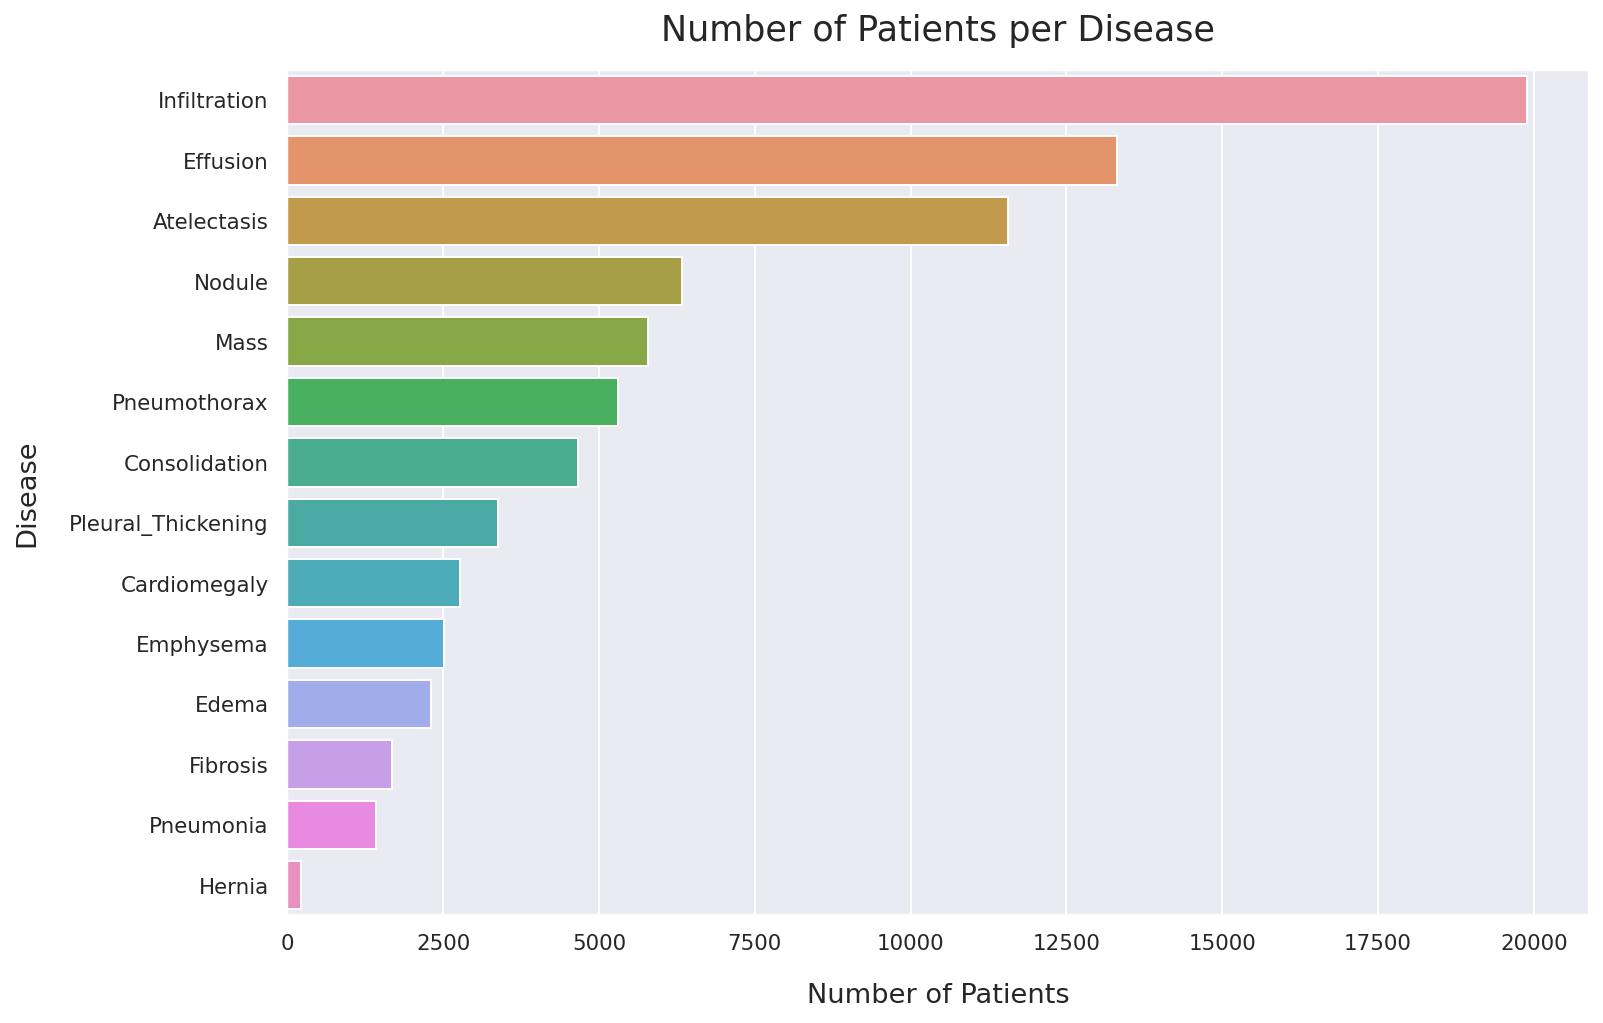

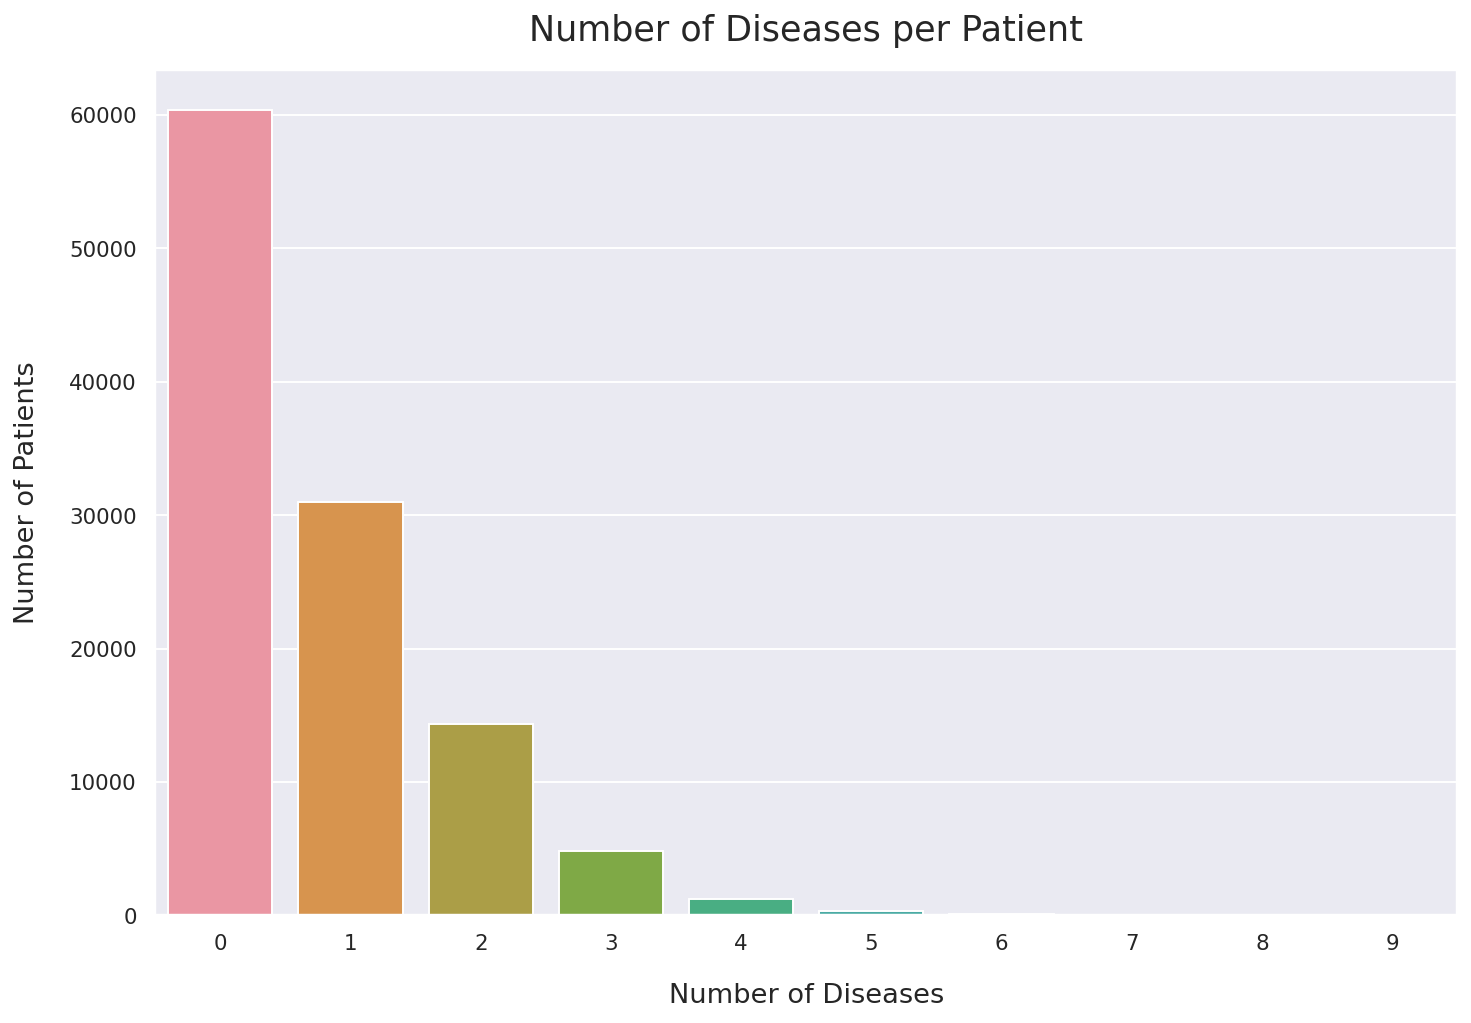

In [21]:
# What are the label counts for each disease?
label_counts = df[diseases].sum().sort_values(ascending=False)
# Plot the value counts
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.xlabel('Number of Patients')
plt.ylabel('Disease')
plt.title('Number of Patients per Disease')

# How many diseases does each patient have?
label_counts = df[diseases].sum(axis=1).value_counts().sort_index()
# Plot the value counts
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Patients')
plt.title('Number of Diseases per Patient')

One can notice here that the dataset is highly imbalanced. The number of images with no findings is 60 times more than the number of images with findings. This is a huge class imbalance. This can be seen in the following plot. This is very typical for medical datasets. 

Text(0.5, 1.0, 'Percentage of Each Disease')

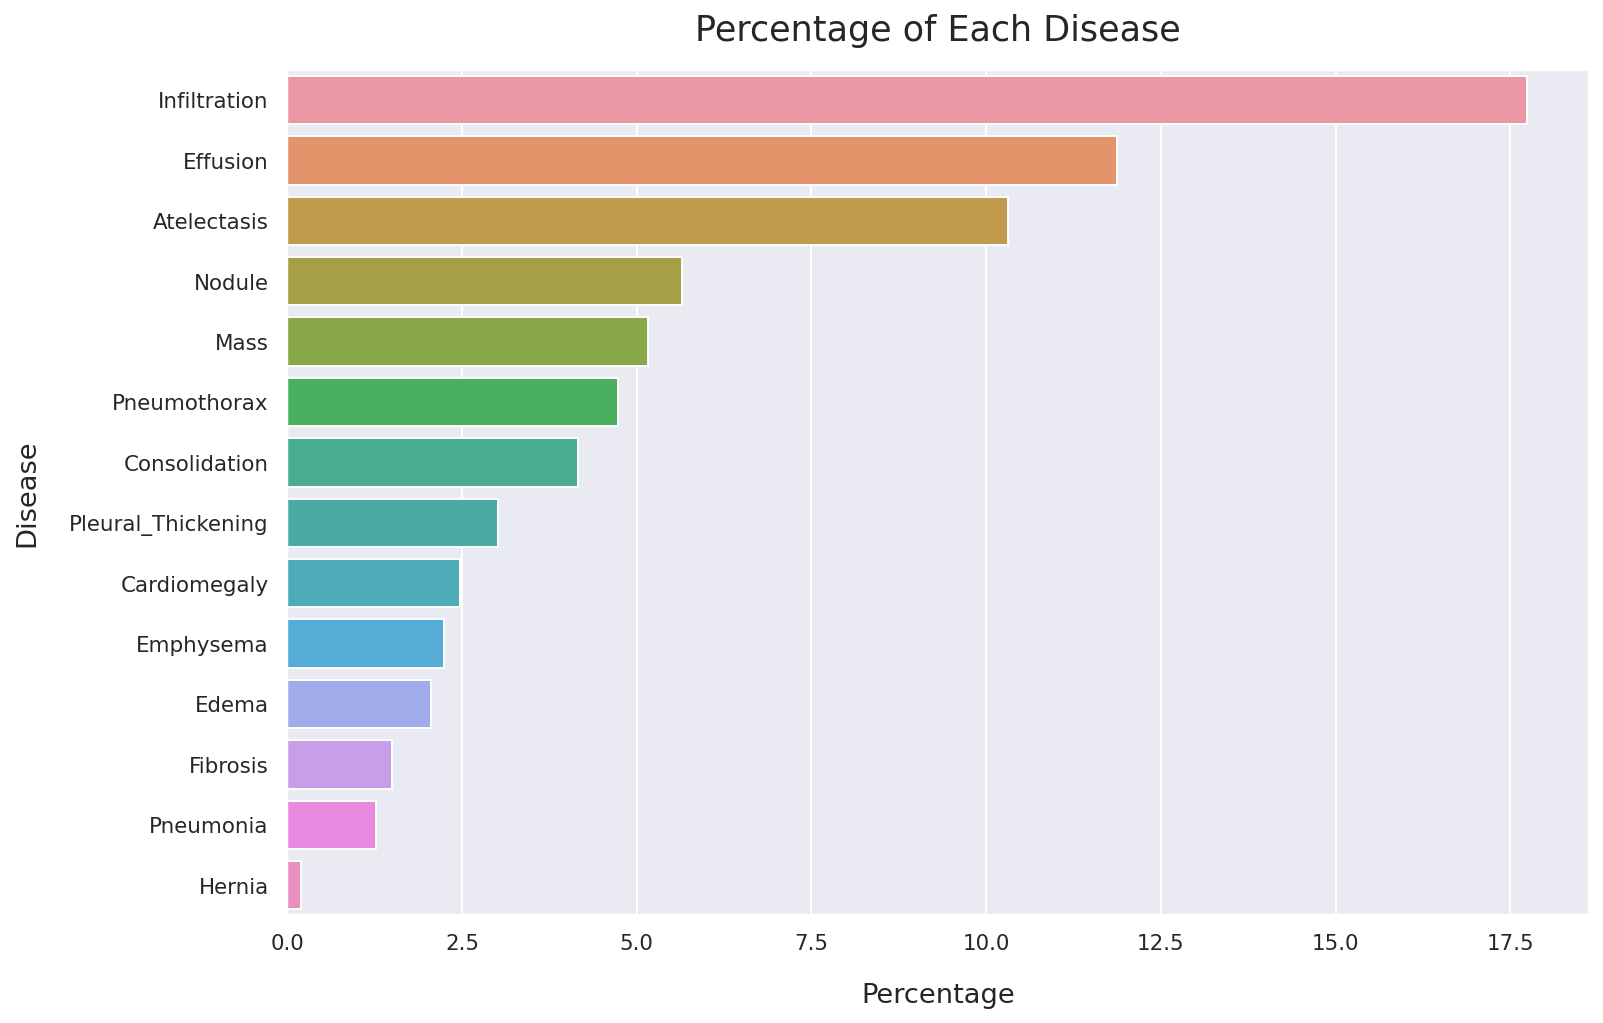

In [22]:
# Get the unique labels
unique_labels = df[diseases].sum().sort_values(ascending=False)
# Plot the percentage of each label
plt.figure(figsize=(12, 8))
sns.barplot(x=unique_labels.values / len(df) * 100, y=unique_labels.index)
plt.xlabel('Percentage')
plt.ylabel('Disease')
plt.title('Percentage of Each Disease')

We have some underrepresented diseases, namely from hernia to nodule. We will use data augmentation to increase the number of images for these diseases.

In [26]:
# melt the dataframe to convert the diseases to rows
melted_df = pd.melt(df[diseases])
# get the count of each disease
count_df = melted_df.groupby(['variable', 'value']).size().reset_index().rename(columns={0: 'count'})

# calculate the total count for each 'variable'
total_count = count_df.groupby('variable')['count'].transform('sum')

# calculate the percentage of each disease
count_df['percentage'] = count_df['count'] / total_count * 100

count_df.head()

,variable,value,count,percentage
0,Atelectasis,0,100561,89.690510
1,Atelectasis,1,11559,10.309490
2,Cardiomegaly,0,109344,97.524081
3,Cardiomegaly,1,2776,2.475919
4,Consolidation,0,107453,95.837496


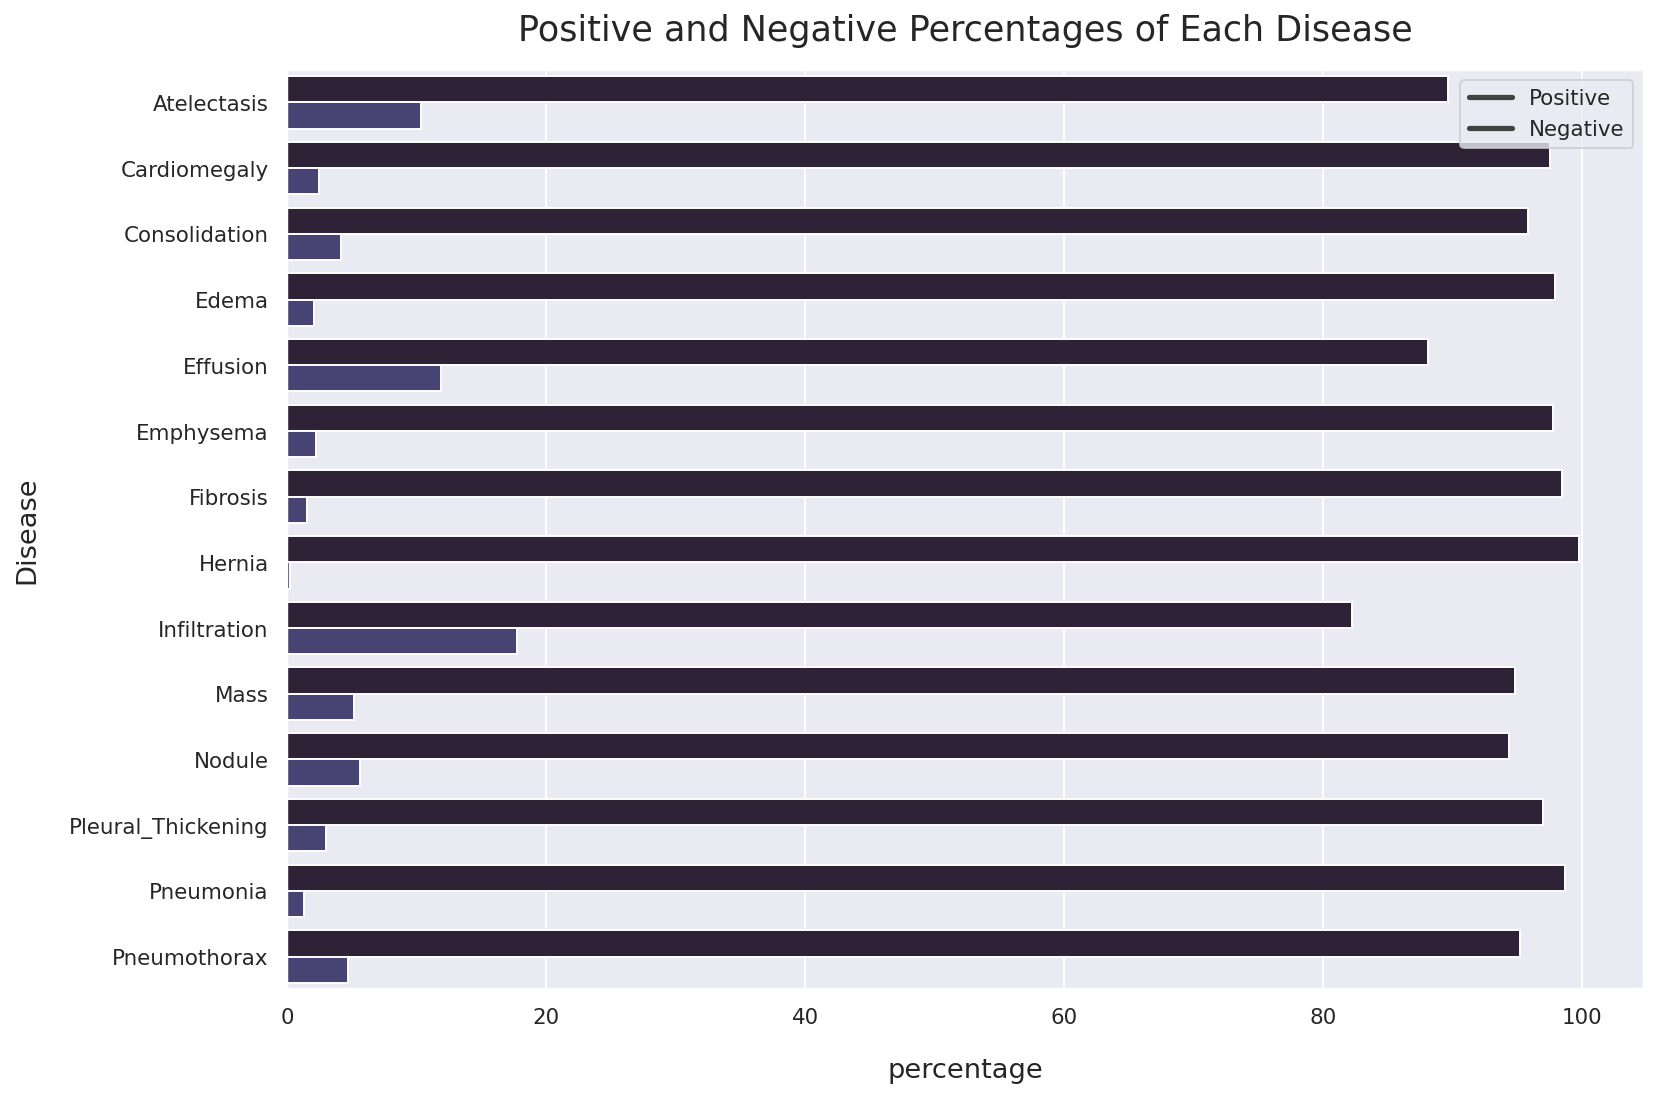

In [29]:
# plot the percentage of each disease
plt.figure(figsize=(12, 8))
sns.barplot(x='percentage', y='variable', hue='value', data=count_df)
plt.xlabel('percentage')
plt.ylabel('Disease')
plt.title('Positive and Negative Percentages of Each Disease')
plt.legend(['Positive', 'Negative'])
plt.tight_layout()

Here one can see that the number of positive cases is very low for most of the diseases. This is a huge class imbalance. This can be seen in the following plot. This is very typical for medical datasets. A model will perform very poorly on such a dataset, given a metric like f1-score or roc-auc score. These metrics are mostly used for imbalanced datasets. 

It's important to take into account the major class imbalance in the dataset. Therefore metrics like accuracy are not suitable for this dataset. This is because the model can achieve a high accuracy by predicting the majority class for all the images. 

If one uses a metric like f1-score or roc-auc score, the model will perform poorly on the "not augmented" dataset. This is because these metrics take into account the number of true positives, false positives, true negatives and false negatives.

This means the dataset will perform very good given the accuracy metric, but it will perform poorly on the minority classes, and this will be reflected in the f1-score and roc-auc score.

In order to overcome this we will use data augmentation to increase the number of images for these diseases, and also make the dataset more balanced.

Also data leakage is a problem in this dataset. This is because the same patient can have multiple images in the dataset. This means that the model can learn to predict the disease based on the patient, and not on the image. This is a problem because the model will not be able to generalize well on new patients.

In [30]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)
df.head()

,Image Path,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Creating test, train and validation sets

In [31]:
IMG_SIZE = [224, 224]
BATCH_SIZE = 32

# used for handling data leak
patient_ids = df['Patient ID'].unique()
# Split the patient IDs into train, validation, and test sets
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=0)
train_ids, val_ids = train_test_split(train_ids, test_size=0.26, random_state=0) # 0.26 x 0.8 ~= 0.2

# Create dataframes for train, validation, and test sets
train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]

# Check the shapes of the dataframes
print('train_df shape:', train_df.shape)
print('val_df shape:', val_df.shape)
print('test_df shape:', test_df.shape)

# Check the ratios of the dataframes as we split based on patient IDs, not individual images
print('train_df ratio:', round(len(train_df) / len(df), 3))
print('val_df ratio:', round(len(val_df) / len(df), 3))
print('test_df ratio:', round(len(test_df) / len(df), 3))

# Drop the 'Patient ID' column
train_df = train_df.drop('Patient ID', axis=1).reset_index(drop=True)
val_df = val_df.drop('Patient ID', axis=1).reset_index(drop=True)
test_df = test_df.drop('Patient ID', axis=1).reset_index(drop=True)

train_df.size, val_df.size, test_df.size

train_df shape: (66543, 16)
val_df shape: (23514, 16)
test_df shape: (22063, 16)
train_df ratio: 0.593
val_df ratio: 0.21
test_df ratio: 0.197


(998145, 352710, 330945)

In [33]:
train_df

,Image Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66538,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66539,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66540,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66541,/cluster/home/taheeraa/datasets/chestxray-14/i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Train, validation and test split analysis

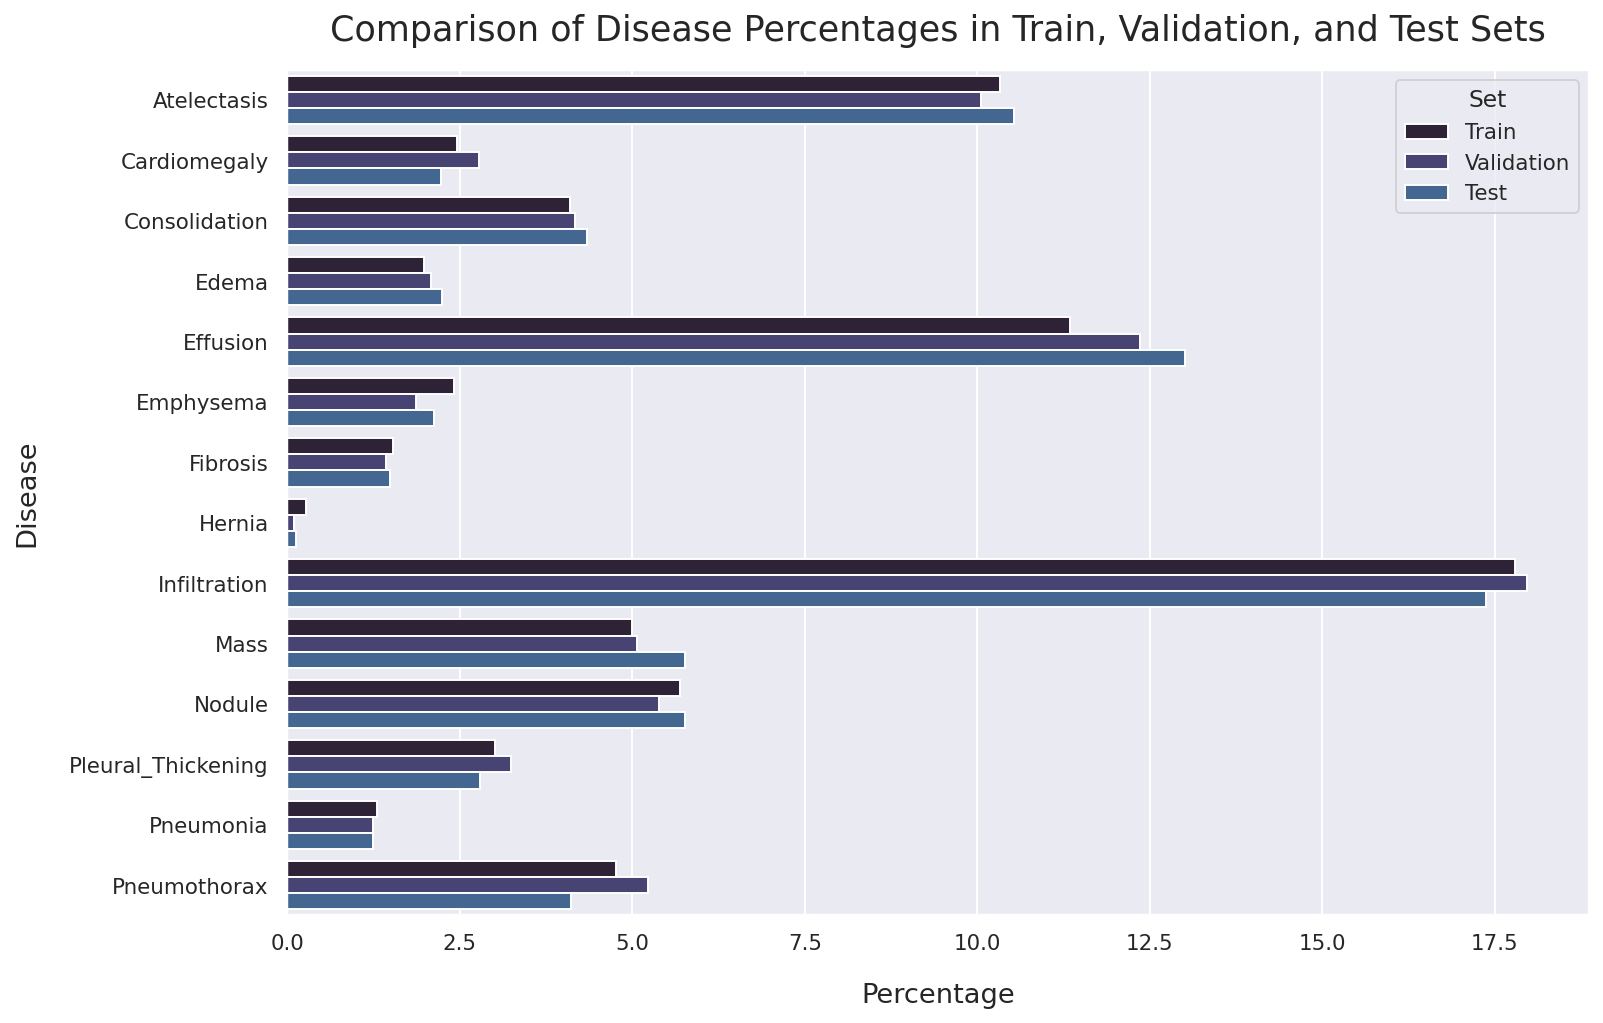

In [32]:
# calculate the percentages of each disease in the train, validation, and test sets
train_percentages = train_df[diseases].mean() * 100
val_percentages = val_df[diseases].mean() * 100
test_percentages = test_df[diseases].mean() * 100

# create a DataFrame that contains the calculated percentages
percentage_df = pd.DataFrame({
    'Disease': diseases,
    'Train': train_percentages,
    'Validation': val_percentages,
    'Test': test_percentages
})

# melt the DataFrame from wide format to long format for plotting
percentage_df = percentage_df.melt(id_vars='Disease', var_name='Set', value_name='Percentage')

# create a bar plot that compares the percentages of each disease in the train, validation, and test sets
plt.figure(figsize=(12, 8))
sns.barplot(data=percentage_df, x='Percentage', y='Disease', hue='Set', alpha=1)
plt.title('Comparison of Disease Percentages in Train, Validation, and Test Sets')
plt.show()

Here one can see the different distributions of the diseases in the train, validation and test sets. The distributions are very similar, which is good. This means that the train, validation and test sets are representative of the entire dataset.

### Finding class weights

In [ ]:
class_weights = []

for i, disease in enumerate(diseases):
    # count the number of positive and negative instances for this disease
    n_positive = np.sum(train_df[disease])
    n_negative = len(train_df) - n_positive

    # compute the weight for positive instances and the weight for negative instances
    weight_for_positive = (1 / n_positive) * (len(train_df) / 2.0)
    weight_for_negative = (1 / n_negative) * (len(train_df) / 2.0)

    class_weights.append({0: weight_for_negative, 1: weight_for_positive})

class_weights

[{0: 0.5575824102160178, 1: 4.841603608847497},
 {0: 0.5125868523625383, 1: 20.361995104039167},
 {0: 0.5213824552606011, 1: 12.191828508611213},
 {0: 0.5101034879264086, 1: 25.24393019726859},
 {0: 0.5639332870048644, 1: 4.410326086956522},
 {0: 0.5123973942371368, 1: 20.66552795031056},
 {0: 0.5077912762125698, 1: 32.5871694417238},
 {0: 0.5013259601910588, 1: 189.04261363636365},
 {0: 0.6081985193309569, 1: 2.810567663456665},
 {0: 0.5262562674975879, 1: 10.021536144578315},
 {0: 0.5302062085670577, 1: 8.776444209970984},
 {0: 0.5155494607660841, 1: 16.577727952167415},
 {0: 0.5065928711725566, 1: 38.41974595842956},
 {0: 0.5249775155024694, 1: 10.509001895135818}]

In [13]:
train_df

NameError: name 'train_df' is not defined